In [12]:
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Download main dataset

What to improve: 

- add static info from profile
- add tstaic geatures from 
- add extra

In [13]:
target_series = pd.read_parquet('data/target_series.parquet')
calendar = pd.read_csv('data/calendar.csv', parse_dates=['date'])
profiles = pd.read_parquet('data/profiles.parquet')

In [14]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['date'] = calendar['date'].dt.tz_localize(None)

train_calendar = calendar[calendar['part'] == 'train'][['date', 'week']]
private_calendar = calendar[calendar['part'] == 'private'][['date', 'week']]
public_calendar = calendar[calendar['part'] == 'public'][['date', 'week']]

# Baseline1

In [15]:
# ensure that the latest version of the SageMaker SDK is available
import lightning.pytorch as pl
import torch

from metrics.metrics import RMSLE
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import QuantileLoss, SMAPE, MAE, RMSE
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

In [16]:
hyperparams = dict(
    min_encoder_length=12,
    max_encoder_length=2*12,
    min_prediction_length=1,
    max_prediction_length=12,
    batch_size=1024,
    quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
    learning_rate=3e-5,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=64,
    
)

In [17]:
data = target_series
data.index = range(0, len(data))
data = data.astype({
    "inn_id": "category",
    "target": "float",
    "week": "int",
})
weeks = train_calendar['week'].unique()
train_timeframe = weeks[:-hyperparams['max_prediction_length']]
val_timeframe = weeks[-hyperparams['max_prediction_length']:]
train_data = data[data['week'].isin(train_timeframe)]

In [20]:
training_tft = TimeSeriesDataSet(
        train_data,
        time_idx="week",
        target="target",
        group_ids=["inn_id"],
        min_encoder_length=hyperparams['min_encoder_length'],
        max_encoder_length=hyperparams['max_encoder_length'],
        min_prediction_length=hyperparams['min_prediction_length'],
        max_prediction_length=hyperparams['max_prediction_length'],
        static_categoricals=["inn_id"],
        categorical_encoders={
            "inn_id": NaNLabelEncoder(add_nan=True),
        },
        time_varying_known_reals=["week"],
        time_varying_unknown_reals=["target"],
        target_normalizer=GroupNormalizer(groups=["inn_id"]),
        add_relative_time_idx=True,
        add_encoder_length=True,
        add_target_scales=True
)
validation_tft = TimeSeriesDataSet.from_dataset(training_tft, data, predict=True, stop_randomization=True)

In [21]:
model = TemporalFusionTransformer.from_dataset(
    training_tft,
    learning_rate=hyperparams['learning_rate'],
    hidden_size=hyperparams['hidden_size'],
    attention_head_size=hyperparams['attention_head_size'],
    dropout=hyperparams['dropout'],
    hidden_continuous_size=hyperparams['hidden_continuous_size'],
    output_size=len(hyperparams['quantiles']),
    loss=QuantileLoss(quantiles=hyperparams['quantiles']),
    logging_metrics=torch.nn.ModuleList([
        SMAPE(),
        MAE(),
        RMSE(),
        RMSLE(),
    ]),
    log_interval=10, 
    optimizer="adam",
    reduce_on_plateau_patience=500,
)
print(f"Number of parameters in network: {model.size() / 1e3:.1f}k")

/Users/germankochnev/Desktop/projects/data-fusion-forecasting/venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/germankochnev/Desktop/projects/data-fusion-forecasting/venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 6225.6k


In [22]:
train_dataloader = training_tft.to_dataloader(train=True, batch_size=hyperparams['batch_size'], num_workers=0)
val_dataloader = validation_tft.to_dataloader(train=False, batch_size=hyperparams['batch_size'], num_workers=0)

In [ ]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="mps",
    enable_model_summary=True,
    val_check_interval=0.5,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 5.2 M  | train
3  | prescalers                         | ModuleDict                      | 768    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 78.8 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 78.2 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 52.0 K | train
7  | static_context_variable_selection  | GatedResidualNetw

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/germankochnev/Desktop/projects/data-fusion-forecasting/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/Users/germankochnev/Desktop/projects/data-fusion-forecasting/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/5328 [00:00<?, ?it/s] 

# Baseline2

In [4]:
# ensure that the latest version of the SageMaker SDK is available
import os
import argparse
import logging
import sys
import pandas as pd
from os.path import join
import json
import numpy as np
import uuid
import lightning.pytorch as pl
import subprocess
import torch

from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import QuantileLoss, SMAPE, MAE, RMSE

import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

/Users/germankochnev/Desktop/projects/data-fusion-forecasting/venv/lib/python3.12/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### Download

In [5]:
transaction_files = [
    'data/transactions_1.parquet',
    'data/transactions_2.parquet',
    'data/transactions_3.parquet',
    'data/transactions_4.parquet',
]
transction_details = None
for file in tqdm(transaction_files):
    transactions = pd.read_parquet(file)
    if transction_details is None:
        transction_details = transactions
    else:
        transction_details = pd.concat([transction_details, transactions])
transction_details['inn_id'] = transction_details['doc_payer_inn']

100%|██████████| 4/4 [00:32<00:00,  8.16s/it]


### Filtering

In [6]:
unique_inns = target_series['inn_id'].unique()
transaction_details_filtered = transction_details[transction_details['doc_payer_bank_name_flag'] == 1]
transaction_details_filtered = transaction_details_filtered[transaction_details_filtered['inn_id'].isin(unique_inns)]

In [7]:
import gc

del transction_details
del transactions
gc.collect()

120

### Mapping and aggreagting

In [8]:
transaction_details_filtered['date'] = transaction_details_filtered['date'].dt.tz_localize(None)
transaction_details_filtered_grouped = transaction_details_filtered.groupby(['inn_id', 'date']).agg(trns_amount_sum=('trns_amount', 'sum'), trns_count=('trns_amount', 'count')).reset_index()

In [9]:
def merge_group(group):
    inn_id = group['inn_id'].iloc[0]
    group = group.merge(train_calendar, on='date', how='outer')
    group['inn_id'] = inn_id
    group.fillna(0, inplace=True)
    return group

transaction_details_filtered_grouped = transaction_details_filtered_grouped.groupby('inn_id', group_keys=False).apply(merge_group)
transaction_details_filtered_grouped['day'] = transaction_details_filtered_grouped['date'].dt.day
transaction_details_filtered_grouped['month'] = transaction_details_filtered_grouped['date'].dt.month
transaction_details_filtered_grouped['time_index'] = (transaction_details_filtered_grouped['date'] - transaction_details_filtered_grouped['date'].min()).dt.days

/var/folders/6h/prv76kd151d6bp5g1g301l300000gn/T/ipykernel_50001/511580465.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transaction_details_filtered_grouped = transaction_details_filtered_grouped.groupby('inn_id', group_keys=False).apply(merge_group)


### Asserts

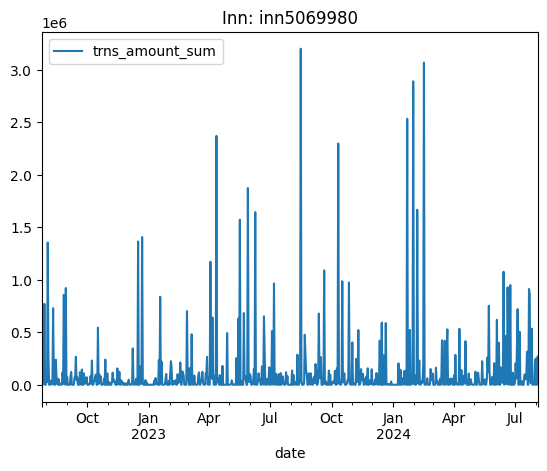

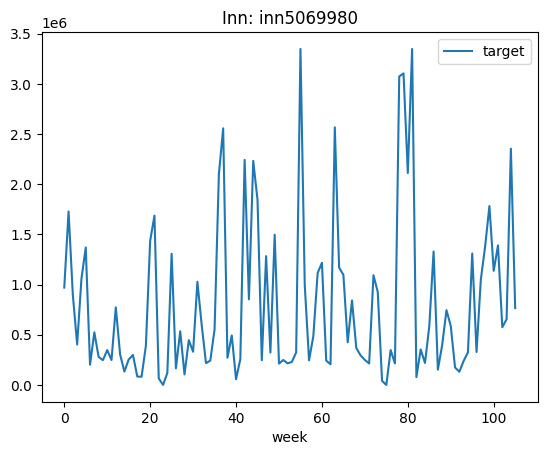

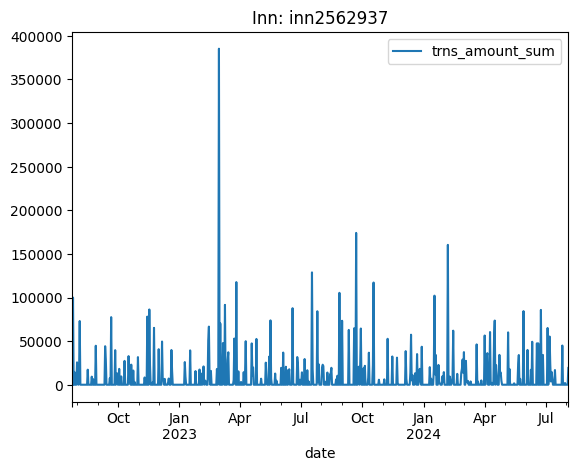

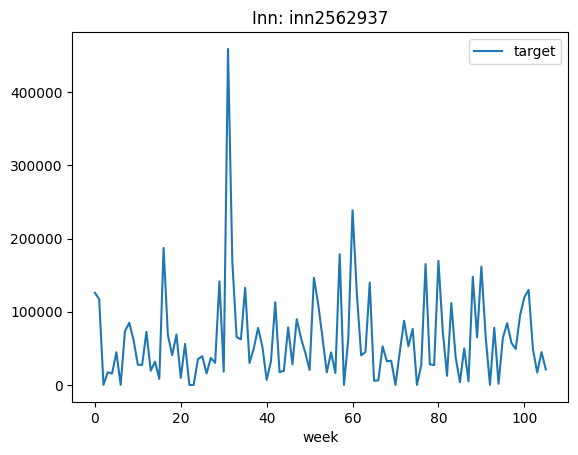

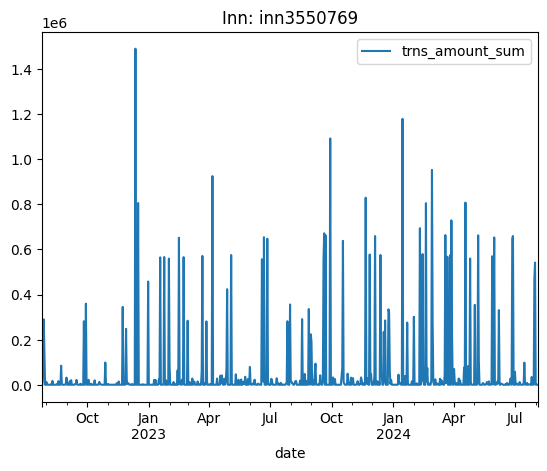

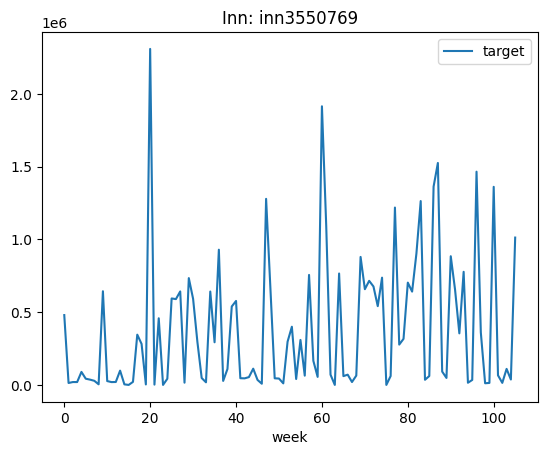

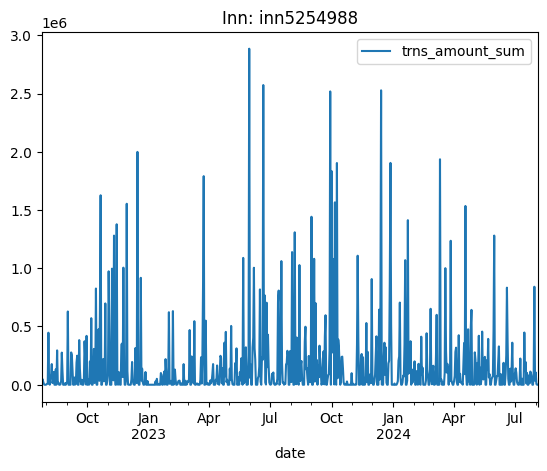

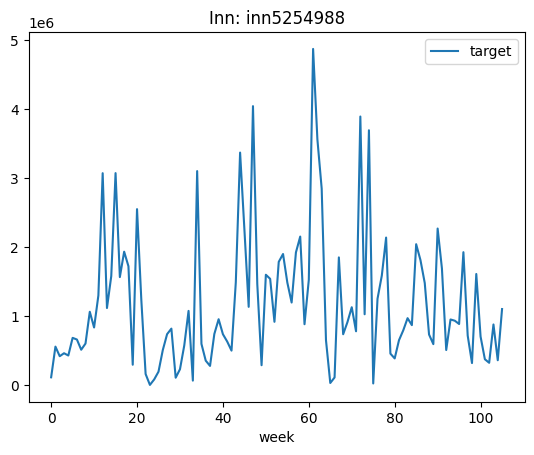

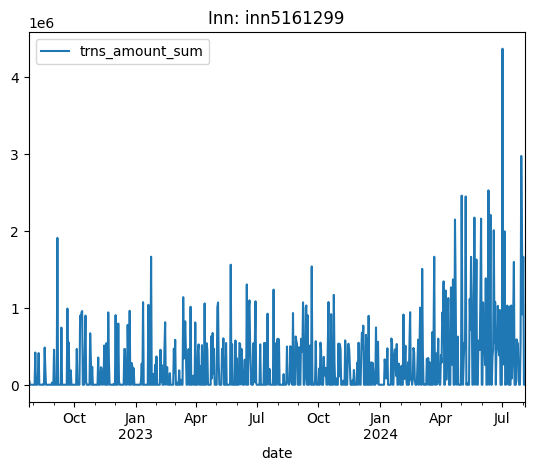

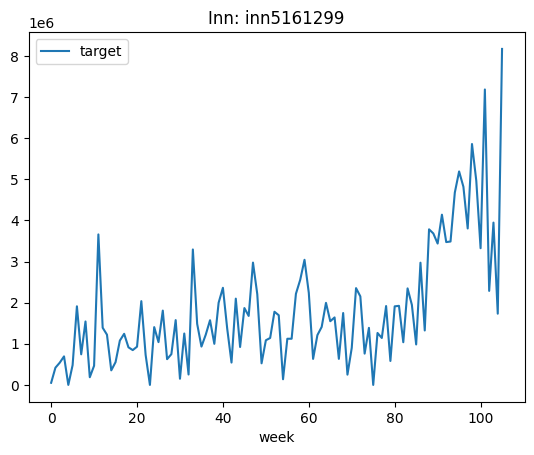

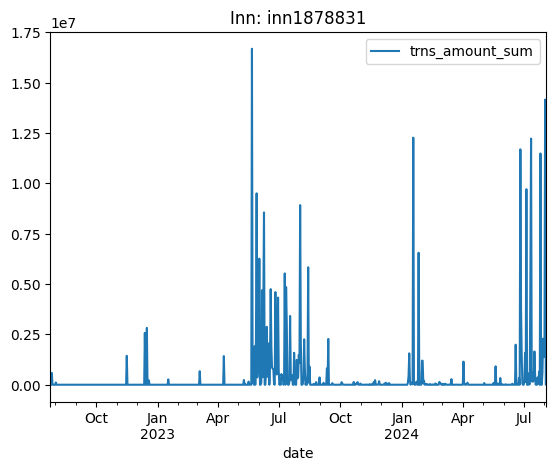

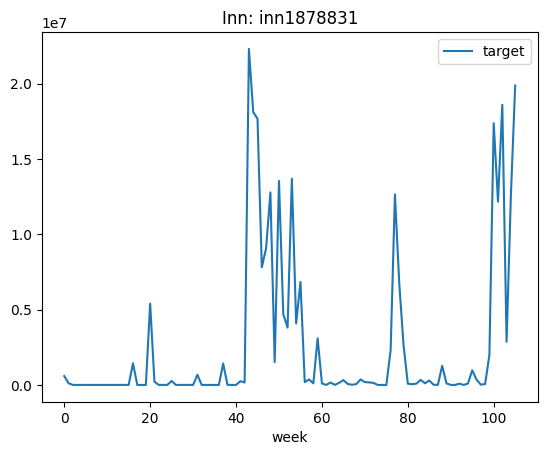

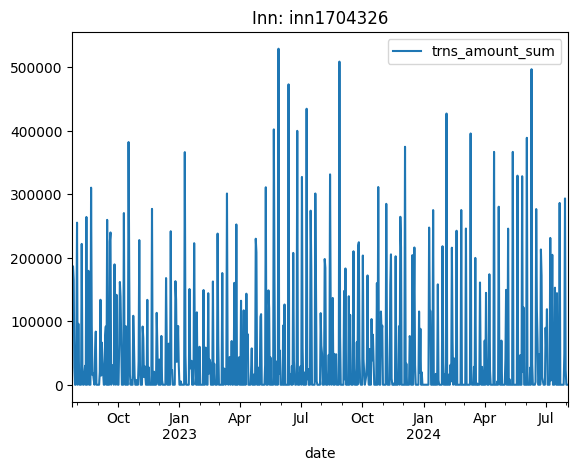

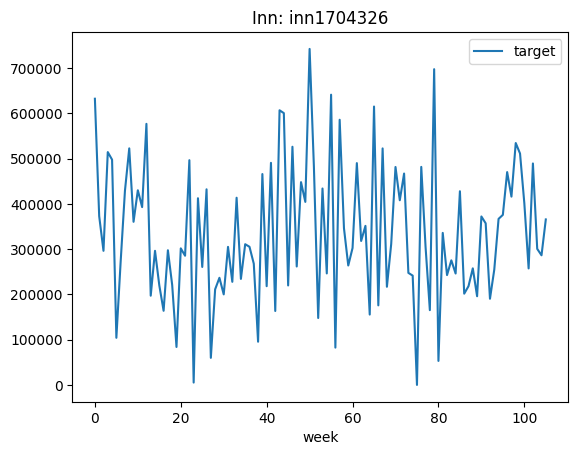

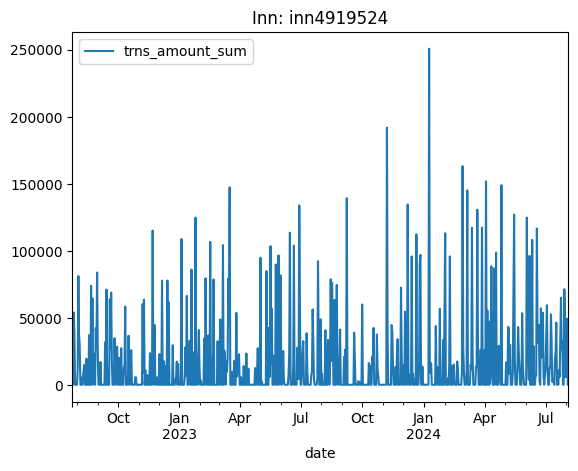

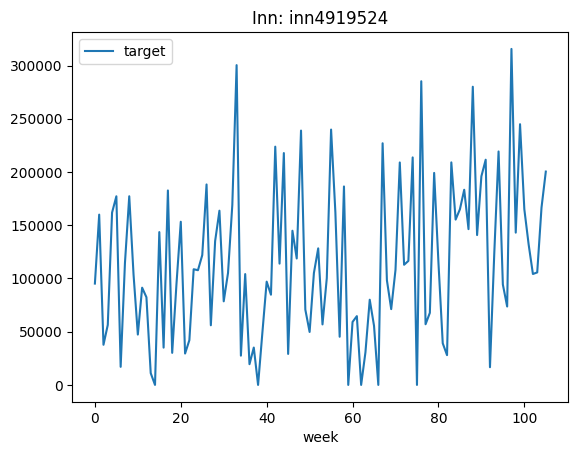

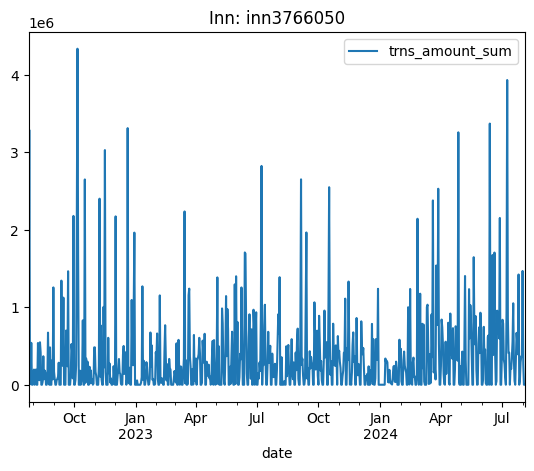

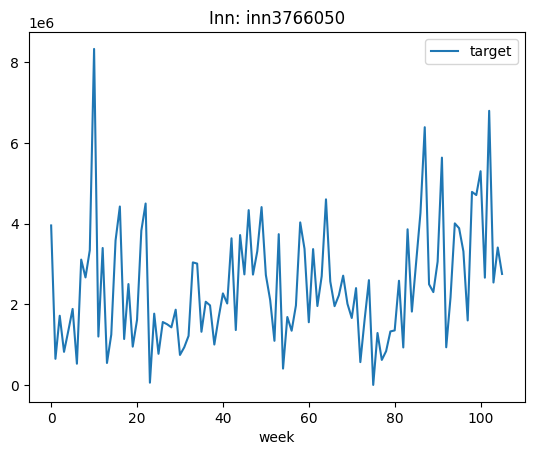

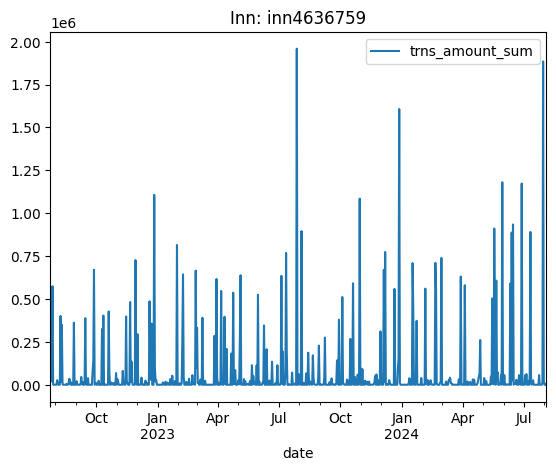

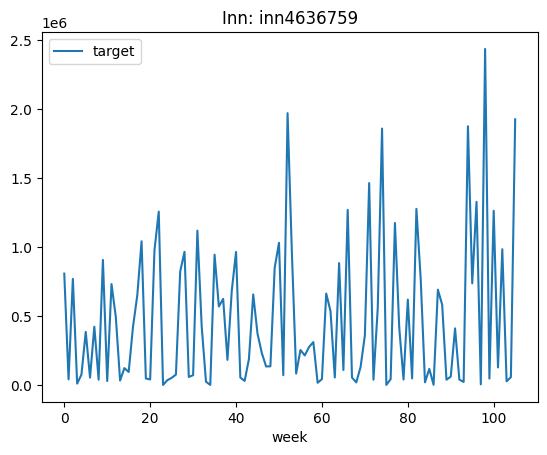

In [10]:
data_to_assert = transaction_details_filtered_grouped.groupby(['inn_id', 'week']).agg(target=('trns_amount_sum', 'sum')).reset_index()
inns = data_to_assert['inn_id'].sample(10)

for inn in inns:
    assert np.isclose(target_series[target_series['inn_id'] == inn]['target'], data_to_assert[data_to_assert['inn_id'] == inn]['target'], atol=0.01).all()
    
    transaction_details_filtered_grouped[transaction_details_filtered_grouped['inn_id'] == inn].plot(x='date', y='trns_amount_sum', title=f'Inn: {inn}')
    data_to_assert[data_to_assert['inn_id'] == inn].plot(x='week', y='target', title=f'Inn: {inn}')

### Baseline model tft

In [26]:
hyperparams = dict(
    min_encoder_length=84,
    max_encoder_length=2*84,
    min_prediction_length=1,
    max_prediction_length=84,
    batch_size=64,
    quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
    learning_rate=3e-5,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=64,
    
)

In [27]:
data = transaction_details_filtered_grouped
data.index = range(0, len(data))
data = data.astype({
    "day": "str",
    "month": "str",
})
data = data.astype({
    "inn_id": "category",
    "trns_amount_sum": "float",
    "trns_count": "float",
    "week": "float",
    "day": "category",
    "month": "category",
})

train_timeframe = train_calendar[:-hyperparams['max_prediction_length']]
val_timeframe = train_calendar[-hyperparams['max_prediction_length']:]
train_data = data[data['date'].isin(train_timeframe['date'])]


In [28]:
training_tft = TimeSeriesDataSet(
        train_data,
        time_idx="time_index",
        target="trns_amount_sum",
        group_ids=["inn_id"],
        min_encoder_length=hyperparams['min_encoder_length'],
        max_encoder_length=hyperparams['max_encoder_length'],
        min_prediction_length=hyperparams['min_prediction_length'],
        max_prediction_length=hyperparams['max_prediction_length'],
        static_categoricals=["inn_id"],
        categorical_encoders={
            "inn_id": NaNLabelEncoder(add_nan=True),
        },
        time_varying_known_categoricals=["month", "day"],
        time_varying_known_reals=["time_index", "week"],
        time_varying_unknown_reals=["trns_amount_sum", "trns_count"],
        target_normalizer=GroupNormalizer(groups=["inn_id"]),
        add_relative_time_idx=True,
        add_encoder_length=True,
        add_target_scales=True
)
validation_tft = TimeSeriesDataSet.from_dataset(training_tft, data, predict=True, stop_randomization=True)

In [29]:
train_dataloader = training_tft.to_dataloader(train=True, batch_size=hyperparams['batch_size'], num_workers=0)
val_dataloader = validation_tft.to_dataloader(train=False, batch_size=hyperparams['batch_size'], num_workers=0)

### Model training

In [30]:
model = TemporalFusionTransformer.from_dataset(
    training_tft,
    learning_rate=hyperparams['learning_rate'],
    hidden_size=hyperparams['hidden_size'],
    attention_head_size=hyperparams['attention_head_size'],
    dropout=hyperparams['dropout'],
    hidden_continuous_size=hyperparams['hidden_continuous_size'],
    output_size=len(hyperparams['quantiles']),
    loss=QuantileLoss(quantiles=hyperparams['quantiles']),
    logging_metrics=torch.nn.ModuleList([
        SMAPE(),
        MAE(),
        RMSE()
    ]),
    log_interval=10, 
    optimizer="adam",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {model.size() / 1e3:.1f}k")

/Users/germankochnev/Desktop/projects/data-fusion-forecasting/venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/germankochnev/Desktop/projects/data-fusion-forecasting/venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 6308.3k


In [ ]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="mps",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
